<a href="https://colab.research.google.com/github/eet182561/LearningPytorch/blob/master/BeakHis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import SaveModelCallback
# Imports for diverse utilities
from shutil import copyfile
import matplotlib.pyplot as plt
import operator
from PIL import Image
from sys import intern   # For the symbol definitions

In [17]:
!/opt/bin/nvidia-smi
!nvcc --version

Sun Nov 24 17:37:44 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    32W / 250W |   3599MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [18]:
!wget http://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz

--2019-11-24 17:37:56--  http://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz
Resolving www.inf.ufpr.br (www.inf.ufpr.br)... 200.17.202.112, 2801:82:80ff:8001:216:c8ff:fe11:aa0e
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4273561758 (4.0G) [application/x-gzip]
Saving to: ‘BreaKHis_v1.tar.gz.1’

BreaKHis_v1.tar.gz. 100%[===================>]   3.98G  16.0MB/s    in 4m 23s  

2019-11-24 17:42:20 (15.5 MB/s) - ‘BreaKHis_v1.tar.gz.1’ saved [4273561758/4273561758]



In [0]:
import tarfile
tf = tarfile.open("BreaKHis_v1.tar.gz")
tf.extractall()

In [0]:
path = Path('/content/BreaKHis_v1/histology_slides/breast/')

In [21]:
path.ls()

[PosixPath('/content/BreaKHis_v1/histology_slides/breast/count_files.sh'),
 PosixPath('/content/BreaKHis_v1/histology_slides/breast/README.txt'),
 PosixPath('/content/BreaKHis_v1/histology_slides/breast/malignant'),
 PosixPath('/content/BreaKHis_v1/histology_slides/breast/benign')]

In [22]:
(path/'malignant').ls()

[PosixPath('/content/BreaKHis_v1/histology_slides/breast/malignant/process_db_stat.py'),
 PosixPath('/content/BreaKHis_v1/histology_slides/breast/malignant/papillary_carcinoma.stat.txt'),
 PosixPath('/content/BreaKHis_v1/histology_slides/breast/malignant/ductal_carcinoma.stat.txt.SOB'),
 PosixPath('/content/BreaKHis_v1/histology_slides/breast/malignant/SOB'),
 PosixPath('/content/BreaKHis_v1/histology_slides/breast/malignant/ductal_carcinoma.stat.txt'),
 PosixPath('/content/BreaKHis_v1/histology_slides/breast/malignant/lobular_carcinoma.stat.txt'),
 PosixPath('/content/BreaKHis_v1/histology_slides/breast/malignant/mucinous_carcinoma.stat.txt')]

In [23]:
phase=['malignant','benign']
btype = ['phyllodes_tumor','fibroadenoma','tubular_adenoma','adenosis']
mtype = ['papillary_carcinoma','ductal_carcinoma','lobular_carcinoma','mucinous_carcinoma']
alltype = btype+mtype;alltype

['phyllodes_tumor',
 'fibroadenoma',
 'tubular_adenoma',
 'adenosis',
 'papillary_carcinoma',
 'ductal_carcinoma',
 'lobular_carcinoma',
 'mucinous_carcinoma']

In [24]:
fnames = get_image_files(path,recurse=True);fnames[:5]

[PosixPath('/content/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-012.png'),
 PosixPath('/content/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-002.png'),
 PosixPath('/content/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-017.png'),
 PosixPath('/content/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-014.png'),
 PosixPath('/content/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-005.png')]

In [0]:
pat = r'SOB\/([^/]+)'

In [0]:
data = ImageDataBunch.from_name_re(path, fnames, pat, ds_tfms=get_transforms(), size=224, bs=64
                                  ).normalize(imagenet_stats)

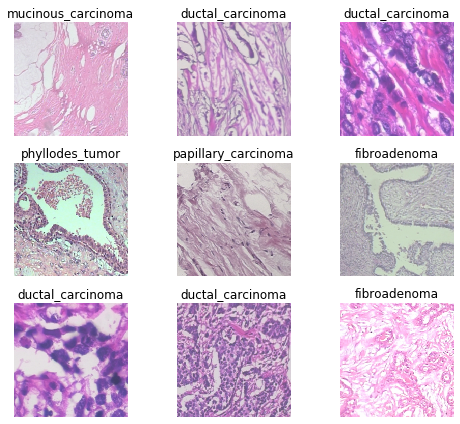

In [27]:
data.show_batch(rows=3, figsize=(7,6))


In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)


In [0]:
learn.unfreeze()

In [30]:
learn.fit_one_cycle(10, max_lr=slice(1e-04,1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,2.192852,1.103897,0.361796,03:43
1,1.264616,0.802327,0.274510,03:40
2,0.873009,0.652758,0.225174,03:37
3,0.657927,0.527924,0.191651,03:38
4,0.523177,0.442433,0.169513,03:37
5,0.411726,0.373478,0.136622,03:38
6,0.304959,0.276317,0.100569,03:38
7,0.230344,0.206938,0.080329,03:37
8,0.156284,0.196709,0.075901,03:38
9,0.129623,0.186672,0.080329,03:37


In [31]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

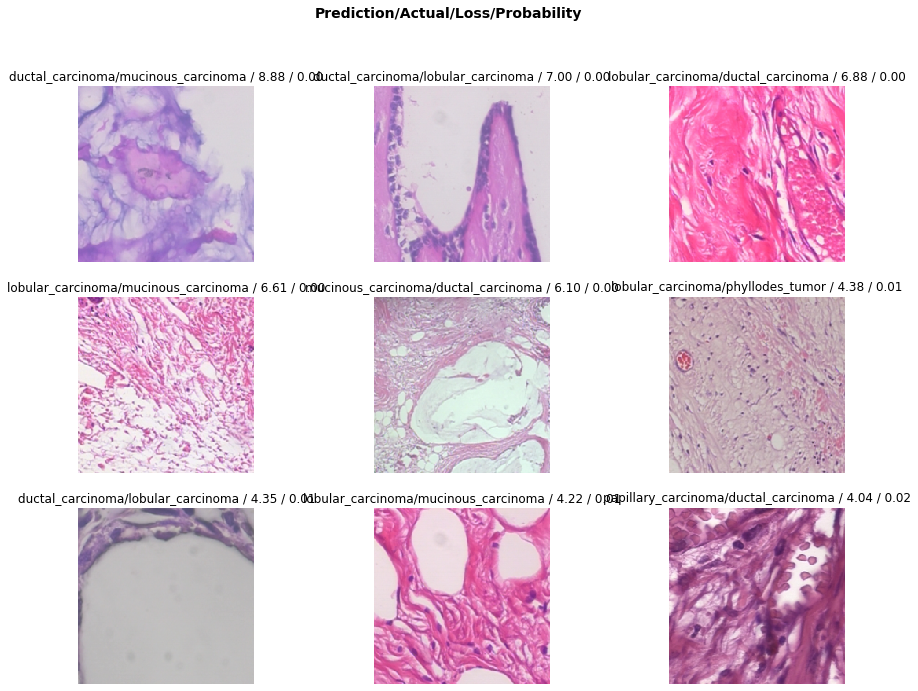

In [32]:
interp.plot_top_losses(9, figsize=(15,11))


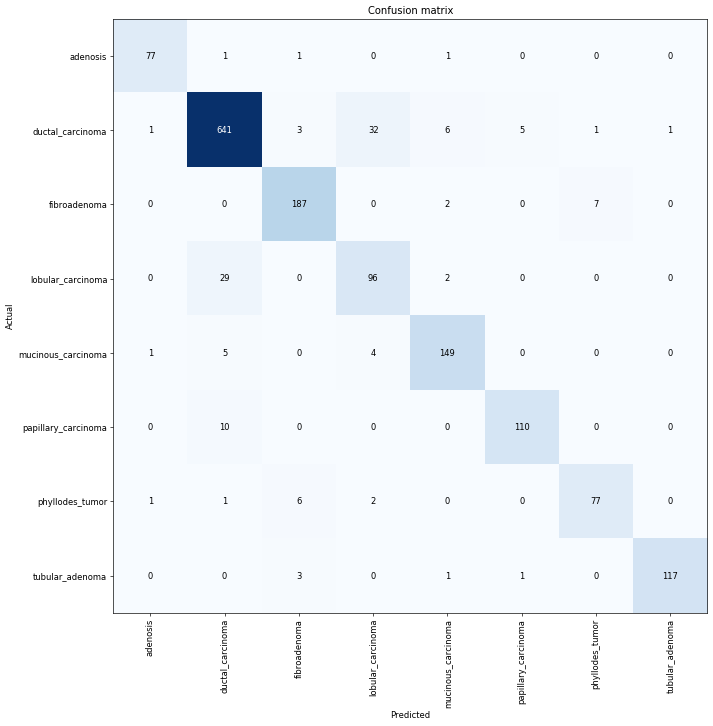

In [33]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


In [34]:
interp.most_confused(min_val=2)


[('ductal_carcinoma', 'lobular_carcinoma', 32),
 ('lobular_carcinoma', 'ductal_carcinoma', 29),
 ('papillary_carcinoma', 'ductal_carcinoma', 10),
 ('fibroadenoma', 'phyllodes_tumor', 7),
 ('ductal_carcinoma', 'mucinous_carcinoma', 6),
 ('phyllodes_tumor', 'fibroadenoma', 6),
 ('ductal_carcinoma', 'papillary_carcinoma', 5),
 ('mucinous_carcinoma', 'ductal_carcinoma', 5),
 ('mucinous_carcinoma', 'lobular_carcinoma', 4),
 ('ductal_carcinoma', 'fibroadenoma', 3),
 ('tubular_adenoma', 'fibroadenoma', 3),
 ('fibroadenoma', 'mucinous_carcinoma', 2),
 ('lobular_carcinoma', 'mucinous_carcinoma', 2),
 ('phyllodes_tumor', 'lobular_carcinoma', 2)]

In [35]:
path.ls()

[PosixPath('/content/BreaKHis_v1/histology_slides/breast/count_files.sh'),
 PosixPath('/content/BreaKHis_v1/histology_slides/breast/README.txt'),
 PosixPath('/content/BreaKHis_v1/histology_slides/breast/malignant'),
 PosixPath('/content/BreaKHis_v1/histology_slides/breast/benign')]

In [37]:
fnames2 = get_image_files(path,recurse = True);fnames2[:5]

[PosixPath('/content/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-012.png'),
 PosixPath('/content/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-002.png'),
 PosixPath('/content/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-017.png'),
 PosixPath('/content/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-014.png'),
 PosixPath('/content/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-005.png')]

In [0]:
pat2 = r'breast\/([a-z]+)'

In [0]:
data2 = ImageDataBunch.from_name_re(path, fnames, pat2, ds_tfms=get_transforms(), size=224, bs=64
                                  ).normalize(imagenet_stats)

In [40]:
print(data2.classes)

['benign', 'malignant']


In [0]:
learn2 = cnn_learner(data2,models.resnet34,metrics=error_rate)

In [44]:
learn2.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.578527,0.337297,0.117015,03:33
1,0.372422,0.245841,0.105629,03:33
2,0.262707,0.179105,0.067679,03:33
3,0.226199,0.173408,0.063884,03:33


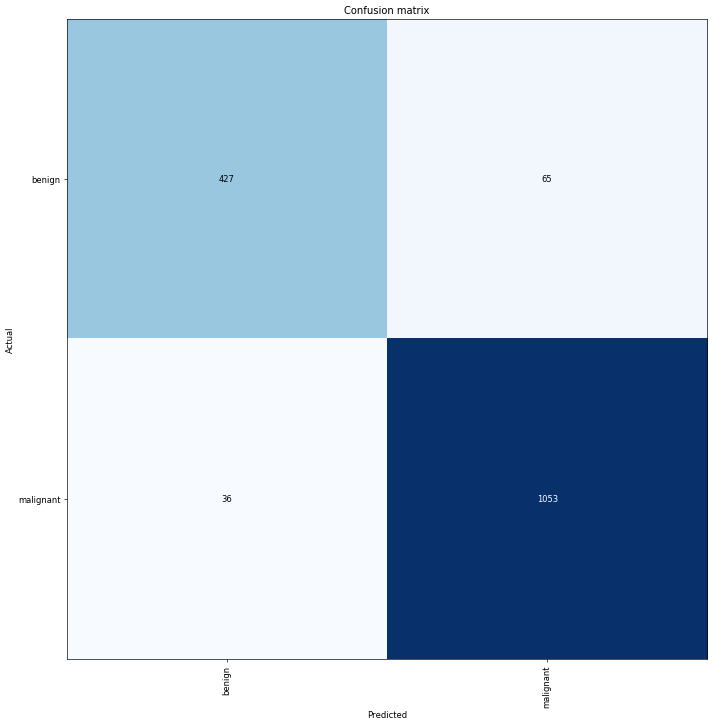

In [45]:
interp2 = ClassificationInterpretation.from_learner(learn2)
interp2.plot_confusion_matrix(figsize=(12,12), dpi=60)

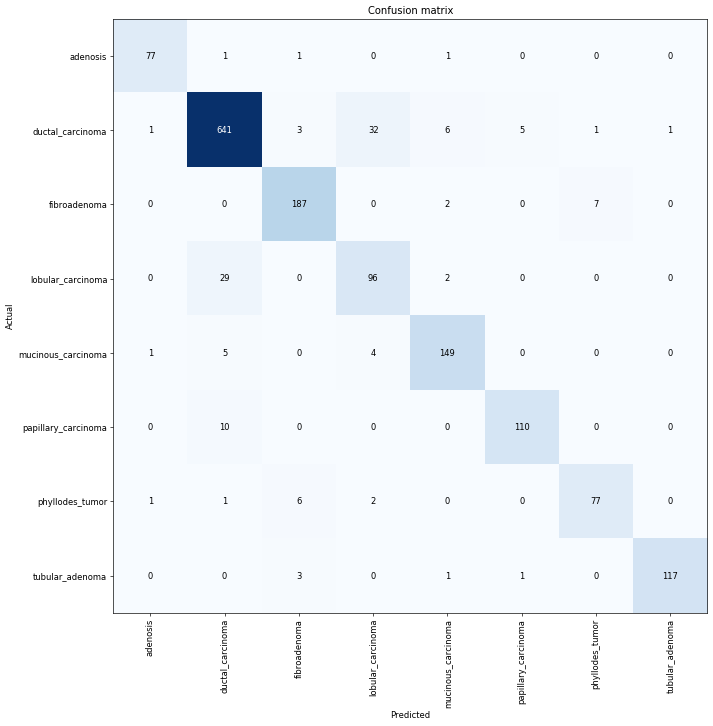

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
